In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
sys.path.append("../../../..") # relative path to module toolkit

In [3]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight 
from keras.backend import clear_session
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


tf.estimator package not installed.
tf.estimator package not installed.


Found 142 images belonging to 3 classes.
Found 38 images belonging to 3 classes.


/usr/local/lib/python2.7/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:105: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Epoch 1/50
48/48 [==============================] - 15s 313ms/step - loss: 1.2880 - acc: 0.5488 - val_loss: 3.5725 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to Scopaeus_resNet50pretrained.h5
Epoch 2/50
48/48 [==============================] - 8s 171ms/step - loss: 0.7024 - acc: 0.7499 - val_loss: 2.7755 - val_acc: 0.4737

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/50
48/48 [==============================] - 9s 190ms/step - loss: 0.6174 - acc: 0.7708 - val_loss: 1.1840 - val_acc: 0.6053

Epoch 00003: val_acc improved from 0.50000 to 0.60526, saving model to Scopaeus_resNet50pretrained.h5
Epoch 4/50
48/48 [==============================] - 8s 171ms/step - loss: 0.3831 - acc: 0.8472 - val_loss: 0.2906 - val_acc: 0.8947

Epoch 00004: val_acc improved from 0.60526 to 0.89474, saving model to Scopaeus_resNet50pretrained.h5
Epoch 5/50
48/48 [==============================] - 8s 173ms/step - loss: 0.2058 - acc: 0.9375 - val_loss: 5.0269 

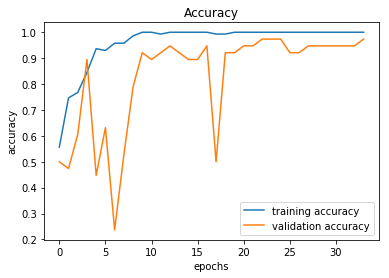

In [4]:
# setup
batch_size = 3
"""
Genus, hvor der kun er en species, så vi behøver ikke at træne modellen.

"Achenium",
"Cafius",
"Creophilus",
"Dinothenarus",
"Emus",
"Erichsonius",
"Euryporus",
"Gabronthus",
"Gauropterus",
"Lobrathium",
"Megalinus",
"Nudobius",
"Paederidus",
"Phacophallus",
"Remus",
"Velleius"
"""


for genus in [
    "Lithocharis",
    "Atrecus",
    "Pseudomedon",
    "Sunius",
    "Astenus",
    "Heterothops",
    "Ocypus",
    "Gabrius",
    "Staphylinus",
    "Acylophorus",
    "Quedius",
    "Philonthus",
    "Medon",
    "Neobisnius",
    "Lathrobium",
    "Paederus",
    "Leptacinus",
    "Platydracus",
    "Ochthephilum",
    "Othius",
    "Gyrohypnus",
    "Bisnius",
    "Tetartopeus",
    "Xantholinus",
    "Rugilus",
    "Tasgius",
    "Ontholestes",
    "Scopaeus"]:

    train_dir = "../../../../../images/images_genus_species_shuffled/train/" + genus + "/"
    val_dir = "../../../../../images/images_genus_species_shuffled/val/" + genus + "/"
    
    labels = getLabelsFromDir(train_dir)

    train_datagen = ImageDataGenerator(rescale=1./255.)
    val_datagen = ImageDataGenerator(rescale=1./255.)
    
    
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True,
                                                    seed=1)
    val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True,
                                                    seed=1)

    number_of_classes = train_generator.num_classes
    train_images = train_generator.samples
    val_images = val_generator.samples
    save_plot_name = genus + "_trainplot.png"
    model_name = genus + '_resNet50pretrained.h5'
    
    steps_per_epoch = int(train_images/batch_size) + 1
    validation_steps = int(val_images/batch_size) + 1
    
    
    ### Model building ####
    base_model = ResNet50(
                include_top=False,
                input_shape=(224, 224, 3),
                weights="imagenet")

    #add a new dense layer to the end of the network inplace of the old layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # add the outplut layer
    predictions = Dense(number_of_classes, activation='softmax')(x)

    # create new model composed of pre-trained network and new final layers
    model = Model(input=base_model.input, output=predictions)

    for layer in model.layers:
        layer.trainable = True
    
    # compile model
    model.compile(loss='categorical_crossentropy',
            optimizer='sgd',
            metrics=['accuracy'])
    
    filepath = model_name

    checkpoint = ModelCheckpoint(filepath=filepath,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True)

    early_stop = EarlyStopping(monitor='val_acc', mode='max', patience=10)

    callbacks = [checkpoint, early_stop]
    
    
    the_class_weight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    #Train
    history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    callbacks=callbacks,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=the_class_weight)
    
    plt.plot(history.history['acc'], label='training accuracy')
    plt.plot(history.history['val_acc'], label='validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(save_plot_name, bbox_inches='tight')
    
    clear_session()
    del model